## Step 2: LSTM_Trinary_Classifier

Using the training and test data sets we constructed in the 1_data_ingestion_and_preparation.ipynb Jupyter notebook, this notebook builds a LSTM network for scenerio described at Predictive Maintenance Template to predict failure in aircraft engines.

In [1]:
import keras

# import the libraries
import h5py
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib
import glob
import pickle
import re

from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential
from sklearn import datasets
from keras.layers import Dense, Dropout, LSTM, Activation

2023-10-17 23:14:21.869213: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load feature data set

We have previously created the labeled data set in the 1_Data Ingestion and Preparation.ipynb Jupyter notebook and stored it in local persistant storage. We define the storage locations for both the notebook input and output here.


In [2]:
CWD = os.getcwd()
train_df = pd.read_csv(os.path.join(CWD,"train_data.csv"))
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0,0.00000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0,0.00277
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0,0.00554
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0,0,0.00831
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0,0,0.01108


In [3]:
test_df = pd.read_csv(os.path.join(CWD,"test_data.csv"))
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,cycle_norm,RUL,label1,label2
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142,0,0
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141,0,0
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140,0,0
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139,0,0
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138,0,0


## Modelling


<!-- The traditional predictive maintenance machine learning models are based on feature engineering, the manual construction of variable using domain expertise and intuition. This usually makes these models hard to reuse as the feature are specific to the problem scenario and the available data may vary between customers. Perhaps the most attractive advantage of deep learning they automatically do feature engineering from the data, eliminating the need for the manual feature engineering step.

When using LSTMs in the time-series domain, one important parameter is the sequence length, the window to examine for failure signal. This may be viewed as picking a window_size (i.e. 5 cycles) for calculating the rolling features in the Predictive Maintenance Template. The rolling features included rolling mean and rolling standard deviation over the 5 cycles for each of the 21 sensor values. In deep learning, we allow the LSTMs to extract abstract features out of the sequence of sensor values within the window. The expectation is that patterns within these sensor values will be automatically encoded by the LSTM.

Another critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. Computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing over such a long period. LSTMs are able to use larger window sizes and use all the information in the window as input.

http://colah.github.io/posts/2015-08-Understanding-LSTMs/ contains more information on the details of LSTM networks.

This notebook illustrates the LSTM approach to binary classification using a sequence_length of 50 cycles to predict the probability of engine failure within 30 days. -->

In [4]:
# pick a large window size of 50 cycles
sequence_length = 50

We use the Keras LSTM with Tensorflow as a backend. Here layers expect an input in the shape of an array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences, time steps is the look back window or sequence length and features is the number of features of each sequence at each time step.

We define a function to generate this array, as we'll use it repeatedly.

In [5]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

The sequences are built from the features (sensor and settings) values across the time steps (cycles) within each engine.

In [6]:
# pick the feature columns 
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
key_cols = ['id', 'cycle']
label_cols = ['label1', 'label2', 'RUL']

input_features = test_df.columns.values.tolist()
sensor_cols = [x for x in input_features if x not in set(key_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(label_cols)]
sensor_cols = [x for x in sensor_cols if x not in set(sequence_cols)]

# The time is sequenced along
# This may be a silly way to get these column names, but it's relatively clear
sequence_cols.extend(sensor_cols)

print(sequence_cols)

['setting1', 'setting2', 'setting3', 'cycle_norm', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']


In [7]:
# generator for the sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(15631, 50, 25)




We also create a function to label these sequences.

In [8]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

We will only be using the LSTM to predict failure within the next 30 days (label1). To predict other labels, we could change this call before building the LSTM network.

In [9]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)






## LSTM Network


Building a Neural Net requires determining the network architecture. In this scenario we will build a network of only 2 layers, with dropout. The first LSTM layer with 100 units, one for each input sequence, followed by another LSTM layer with 50 units. We will also apply dropout each LSTM layer to control overfitting. The final dense output layer employs a sigmoid activation corresponding to the binary classification requirement.

In [10]:
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]
input_shape=(sequence_length, nb_features)
input_shape


(50, 25)

In [10]:
from keras.utils import to_categorical
# Assuming your original target values are in a variable named 'y'
label_array = to_categorical(label_array, num_classes=3)  #

In [11]:
# build the network
# Feature weights
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential([
    LSTM(
        units=100,
        input_shape=(sequence_length,nb_features),
        return_sequences=True
    ),
    Dropout(0.2),   
    LSTM(
        units=50,
        return_sequences=False
    ),    
    Dropout(0.2),
    Dense(units=3,activation='softmax')
])

# With adam optimizer and a categorical crossentropy loss. We will opimize for model accuracy.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Verify the architecture 
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 80753 (315.44 KB)
Trainable params: 80753 (315.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


It takes about 15 seconds per epoch to build this model on a DS4_V2 standard Data Science Virtual Machine for Linux (Ubuntu) using only CPU compute.

In [12]:
# fit the network
history = model.fit(seq_array, # Training features
          label_array, # Training labels
          epochs=50,   
          batch_size=200,
          validation_split=0.10, # Use 10% of data to evaluate the loss. (val_loss)
          verbose=1, #
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', # Monitor the validation loss
                                                     min_delta=0,    # until it doesn't change (or gets worse)
                                                     patience=5,  # patience > 1 so it continutes if it is not consistently improving
                                                     verbose=0, 
                                                     mode='auto')]) 

Epoch 1/50
71/71 [==============================] - 21s 224ms/step - loss: 0.4242 - accuracy: 0.8484 - val_loss: 0.2344 - val_accuracy: 0.8913
Epoch 2/50
71/71 [==============================] - 15s 206ms/step - loss: 0.1794 - accuracy: 0.9249 - val_loss: 0.1750 - val_accuracy: 0.9194
Epoch 3/50
71/71 [==============================] - 14s 200ms/step - loss: 0.1473 - accuracy: 0.9402 - val_loss: 0.1657 - val_accuracy: 0.9194
Epoch 4/50
71/71 [==============================] - 15s 211ms/step - loss: 0.1246 - accuracy: 0.9491 - val_loss: 0.0823 - val_accuracy: 0.9636
Epoch 5/50
71/71 [==============================] - 15s 211ms/step - loss: 0.1120 - accuracy: 0.9511 - val_loss: 0.0954 - val_accuracy: 0.9655
Epoch 6/50
71/71 [==============================] - 15s 206ms/step - loss: 0.1051 - accuracy: 0.9567 - val_loss: 0.0934 - val_accuracy: 0.9636
Epoch 7/50
71/71 [==============================] - 15s 216ms/step - loss: 0.1040 - accuracy: 0.9571 - val_loss: 0.0830 - val_accuracy: 0.9648

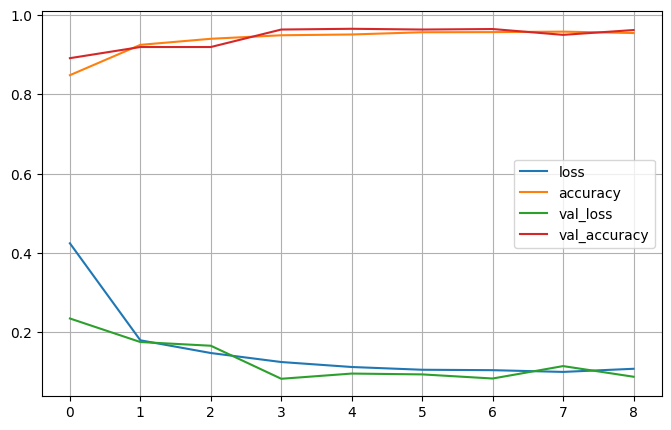

In [13]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
# plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

We optimized the network weights on the training set accuracy, which we examine here.

In [14]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(scores[1]))

79/79 [==============================] - 6s 79ms/step - loss: 0.0879 - accuracy: 0.9643
Training Accurracy: 0.9643017053604126


We can examine the training set performance by looking at the model confusion matrix. Accurate predictions lie along the diagonal of the matrix, errors are on the off diagonal.


In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
# make predictions and compute confusion matrix
y_pred = (model.predict(seq_array) > 0.5).astype("int32")
y_true = label_array

# Assuming 'y_true' contains the true labels and 'y_pred' contains the predicted labels
precision = precision_score(y_true, y_pred, average='micro')  # You can use other averaging strategies
recall = recall_score(y_true, y_pred, average='micro')  # You can use other averaging strategies
f1 = f1_score(y_true, y_pred, average='micro')  # You can use other averaging strategies

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

489/489 [==============================] - 10s 21ms/step
Precision: 0.9652564102564103
Recall: 0.9633420766425692
F1-score: 0.9642982933623644


## Model testing


Next, we look at the performance on the test data. Only the last cycle data for each engine id in the test data is kept for testing purposes. In order to compare the results to the template, we pick the last sequence for each id in the test data.

In [19]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
seq_array_test_last.shape

(93, 50, 25)

We also ned the test set labels in the correct format.


In [20]:
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]

label_array_test_last = test_df.groupby('id')['label2'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
label_array_test_last.shape

label_array_test_last = to_categorical(label_array_test_last, num_classes=3)
print(seq_array_test_last.shape)
print(label_array_test_last.shape)

(93, 50, 25)
(93, 3)


Now we can test the model with the test data. We report the model accuracy on the test set, and compare it to the training accuracy. By definition, the training accuracy should be optimistic since the model was optimized for those observations. The test set accuracy is more general, and simulates how the model was intended to be used to predict forward in time. This is the number we should use for reporting how the model performs

In [21]:
# test metrics
scores_test = model.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
print('Test Accurracy: {}'.format(scores_test[1]))

3/3 - 0s - loss: 0.0926 - accuracy: 0.9677 - 73ms/epoch - 24ms/step
Test Accurracy: 0.9677419066429138


In [22]:
# make predictions and compute confusion matrix
y_pred_test = (model.predict(seq_array_test_last) > 0.5).astype("int32")
y_true_test = label_array_test_last

# compute precision and recall
precision_test = precision_score(y_true_test, y_pred_test,average='micro')
recall_test = recall_score(y_true_test, y_pred_test,average='micro')
f1_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)
print( 'Test Precision: ', precision_test, '\n', 'Test Recall: ', recall_test, '\n', 'Test F1 Score:', f1_test)


3/3 [==============================] - 0s 21ms/step
Test Precision:  0.967741935483871 
 Test Recall:  0.967741935483871 
 Test F1 Score: 0.967741935483871


The confusion matrix uses absolute counts, so comparing the test and training set confusion matrices is difficult. Instead, it is better to use precision and recall.

Precision measures how accurate your model predicts failures. What percentage of the failure predictions are actually failures.
Recall measures how well the model captures thos failures. What percentage of the true failures did your model capture.
These measures are tightly coupled, and you can typically only choose to maximize one of them (by manipulating the probability threshold) and have to accept the other as is.

## Saving the model

The LSTM network is made up of two components, the architecture and the model weights. We'll save these model components in two files, the architecture in a json file that the keras package can use to rebuild the model, and the weights in an HDF5 heirachy that rebuild the exact model.

In [23]:
# Save the model for operationalization: https://machinelearningmastery.com/save-load-keras-deep-learning-models/
import os
import h5py
from sklearn import datasets 
 
# We'll serialize the model in json format
LSTM_MODEL = 'lstm_trinary_model.json'

# and store the weights in h5
MODEL_WEIGHTS = 'lstm_trinary_model.h5'

# save model
# serialize model to JSON
model_json = model.to_json()
with open(LSTM_MODEL, "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights(MODEL_WEIGHTS)
print("Model saved")

Model saved


To test the save operations, we can reload the model files into a test model loaded_model and rescore the test dataset.


In [24]:
from keras.models import model_from_json

print(keras.__version__)

# load json and create model
json_file = open(LSTM_MODEL, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(MODEL_WEIGHTS)

loaded_model.compile('sgd','mse')
print("Model loaded")

2.14.0
Model loaded


The model constructed from storage can be used to predict the probability of engine failure.

In [25]:
score = loaded_model.predict(seq_array,verbose=1)
print(score.shape)
print(score)

489/489 [==============================] - 11s 20ms/step
(15631, 3)
[[9.9980378e-01 1.7445534e-04 2.1767699e-05]
 [9.9979711e-01 1.8061923e-04 2.2422213e-05]
 [9.9978828e-01 1.8837536e-04 2.3231576e-05]
 ...
 [2.0552526e-04 3.9818124e-03 9.9581259e-01]
 [1.7090635e-04 3.2509326e-03 9.9657816e-01]
 [1.4055966e-04 2.5991998e-03 9.9726021e-01]]
